
Training AdaBoost...


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

AdaBoost Accuracy: 0.95
AdaBoost F1 Score: 0.95
AdaBoost ROC-AUC: 0.98984375
Classification Report:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94        40
           1       1.00      0.92      0.96        64

    accuracy                           0.95       104
   macro avg       0.94      0.96      0.95       104
weighted avg       0.96      0.95      0.95       104

Confusion Matrix:
 [[40  0]
 [ 5 59]]

Training Gradient Boosting...
Gradient Boosting Accuracy: 0.99
Gradient Boosting F1 Score: 0.99
Gradient Boosting ROC-AUC: 0.9937499999999999
Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99        40
           1       1.00      0.98      0.99        64

    accuracy                           0.99       104
   macro avg       0.99      0.99      0.99       104
weighted avg       0.99      0.99      0.99       104

Confusion Matrix:
 [[40  0]
 [ 1 63]]

T

<ipython-input-2-3c60173d67e7>:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='accuracy', y=results_df.index, data=results_df.reset_index(), palette='viridis')


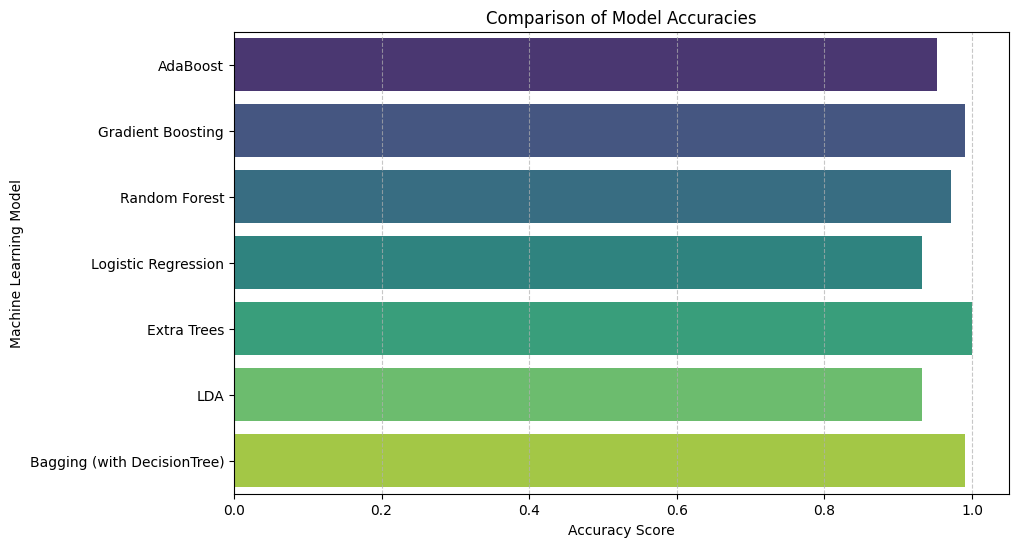

Best Hyperparameters for Random Forest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}
Best Cross-Validated Score for Random Forest: 0.980722891566265

Final Model Test Accuracy: 0.9807692307692307
Classification Report on Test Data:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97        40
           1       0.98      0.98      0.98        64

    accuracy                           0.98       104
   macro avg       0.98      0.98      0.98       104
weighted avg       0.98      0.98      0.98       104

Confusion Matrix on Test Data:
 [[39  1]
 [ 1 63]]


<ipython-input-2-3c60173d67e7>:122: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='magma')


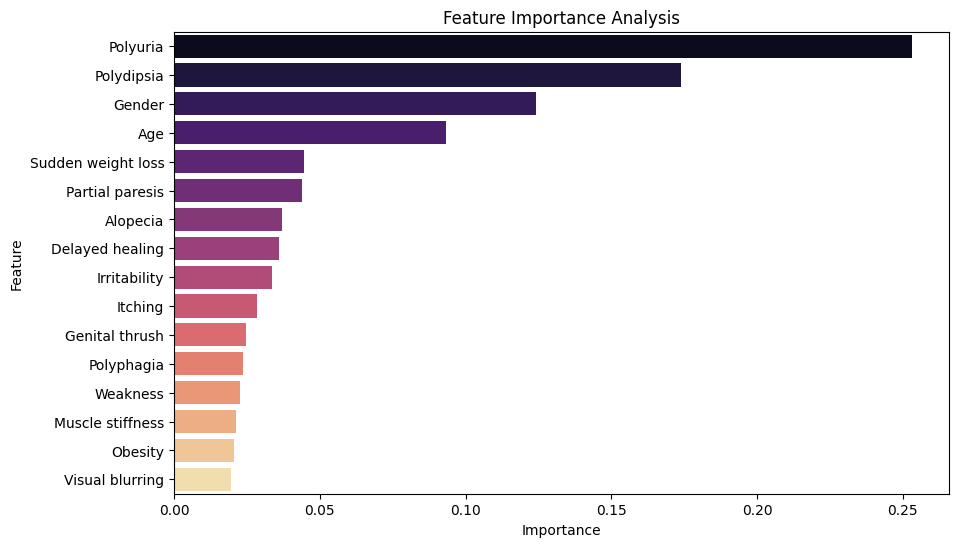

Model and preprocessing saved as final_model_with_preprocessing.pkl


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, f1_score
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import Pipeline
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
file_path = r"final dataset.csv"
data = pd.read_csv(file_path)

# Basic data exploration and cleanup
data = data.dropna()  # Drop rows with any missing values

# Encode categorical columns
categorical_cols = data.select_dtypes(include=['object']).columns
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

# Separate features and target
X = data.drop(columns=['Class'])
y = data['Class']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Dictionary of models with class weights if supported
models = {
    "AdaBoost": AdaBoostClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Random Forest": RandomForestClassifier(class_weight="balanced"),
    "Logistic Regression": LogisticRegression(class_weight="balanced"),
    "Extra Trees": ExtraTreesClassifier(class_weight="balanced"),
    "LDA": LDA(),
    "Bagging (with DecisionTree)": BaggingClassifier()
}

# Train and evaluate each model with cross-validation
results = {}
cv_results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]) if hasattr(model, "predict_proba") else "N/A"
    results[name] = {"accuracy": accuracy, "f1_score": f1, "roc_auc": roc_auc}

    # Cross-validation for stability
    skf = StratifiedKFold(n_splits=5)
    cv_scores = cross_val_score(model, X_train, y_train, cv=skf, scoring="accuracy")
    cv_results[name] = cv_scores.mean()

    print(f"{name} Accuracy: {accuracy:.2f}")
    print(f"{name} F1 Score: {f1:.2f}")
    print(f"{name} ROC-AUC: {roc_auc if roc_auc != 'N/A' else 'Not Available'}")
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Display model performance summary
results_df = pd.DataFrame(results).T
print("\nModel Performance Summary:")
print(results_df)

# Plot model accuracies
plt.figure(figsize=(10, 6))
sns.barplot(x='accuracy', y=results_df.index, data=results_df.reset_index(), palette='viridis')
plt.title('Comparison of Model Accuracies')
plt.xlabel('Accuracy Score')
plt.ylabel('Machine Learning Model')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# Hyperparameter tuning with GridSearchCV for top models
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}
best_models = {}
for name, model in {"Random Forest": RandomForestClassifier(class_weight="balanced")}.items():
    grid_search = GridSearchCV(model, param_grid_rf, cv=skf, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    best_models[name] = grid_search.best_estimator_
    print(f"Best Hyperparameters for {name}: {grid_search.best_params_}")
    print(f"Best Cross-Validated Score for {name}: {grid_search.best_score_}")

# Evaluate the best model on the test set
final_model = best_models["Random Forest"]
final_model.fit(X_train, y_train)
y_test_pred = final_model.predict(X_test)

print("\nFinal Model Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("Classification Report on Test Data:\n", classification_report(y_test, y_test_pred))
print("Confusion Matrix on Test Data:\n", confusion_matrix(y_test, y_test_pred))

# Feature Importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': final_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='magma')
plt.title("Feature Importance Analysis")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

# Save preprocessing steps and model
joblib.dump({"model": final_model, "scaler": scaler, "label_encoders": label_encoders}, "final_model_with_preprocessing.pkl")
print("Model and preprocessing saved as final_model_with_preprocessing.pkl")

# Load and use the model
loaded_data = joblib.load("final_model_with_preprocessing.pkl")
loaded_model = loaded_data["model"]
loaded_scaler = loaded_data["scaler"]
loaded_encoders = loaded_data["label_encoders"]

# Sample prediction (replace `new_data` with actual data)
# Example: new_data = pd.DataFrame([[...]], columns=X.columns)
# new_data_scaled = loaded_scaler.transform(new_data)
# prediction = loaded_model.predict(new_data_scaled)
# print("Prediction:", prediction)


In [ ]:
# Training accuracy
y_train_pred = final_model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)

# Test accuracy (already computed)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")


Training Accuracy: 1.00
Test Accuracy: 0.98


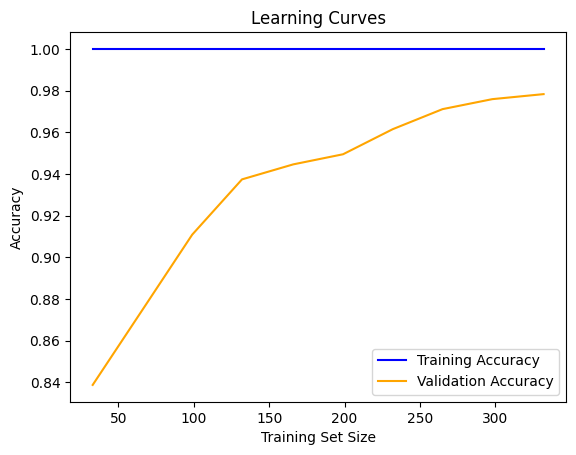

In [ ]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

train_sizes, train_scores, test_scores = learning_curve(
    final_model, X_train, y_train, cv=StratifiedKFold(n_splits=5),
    train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy'
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure()
plt.plot(train_sizes, train_scores_mean, label="Training Accuracy", color="blue")
plt.plot(train_sizes, test_scores_mean, label="Validation Accuracy", color="orange")
plt.title("Learning Curves")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.show()


In [ ]:
from sklearn.model_selection import cross_val_score
import numpy as np

# Example using only one model
model = RandomForestClassifier()
cv_scores = cross_val_score(model, X_train, y_train, cv=5)  # 5-fold cross-validation
cv_std = np.std(cv_scores)
print(f"Cross-Validation Score Standard Deviation: {cv_std:.2f}")

# Example with multiple models
models = {
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Logistic Regression": LogisticRegression()
}

cv_results = {}
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5)
    cv_results[name] = scores
    cv_std = np.std(scores)
    print(f"{name} Cross-Validation Score Standard Deviation: {cv_std:.2f}")


Cross-Validation Score Standard Deviation: 0.01
Random Forest Cross-Validation Score Standard Deviation: 0.01
Gradient Boosting Cross-Validation Score Standard Deviation: 0.02
Logistic Regression Cross-Validation Score Standard Deviation: 0.03
